## Appendix

### Appendix: Breakdown of Code for Segregation in 1D
Early stages of preparing the pipeline. Pipeline above has some updates not reflected here

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import convolve # for counting neighbors in 1d
from scipy.signal import correlate2d # for counting neighbors in 2d
import os, shutil
import imageio
import glob
from tqdm import tqdm
from IPython.display import Image
from skimage.transform import resize
from scipy.stats import invgauss

/Users/prince.javier/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Parameters
n = 20 # neighborhood size with shape (1 x n)
agents = [0, 1, 2] # 0 is empty, 1 and 2 are the agents
props = [0.4, 0.3, 0.3] # proportions of agents must equal one
k = 3 # distance from left and right of agent
thresholds = [0, 0.3, 0.3] # threshold per agent - this is the proportion of similar agents in the locality of an agent for an agent to be happy
    

In [3]:
# we randomly make a neighborhood based on proportions of agents and size n x n
np.random.seed(42) # we can adjust the seed when we're running multiple samples so we still retain replicability
neighborhood = np.random.choice(agents, size=n, replace=True, p=props) 

# define our kernel which we use as the "radius from the agent" to get the nearby neighbors
kernel = np.ones(shape=(k*2+1)) # it's k to the left and right of the agent
kernel[(k*2)//2]=0 # we make the center 0 because we don't want to include the agent 

# mode='same' just means that we return a matrix (of counts of similar neighbors surrounding each cell) with the same shape as the neighborhood
# the conditions are just there to tell the function whether to count or not
agent_1 = neighborhood == 1 # say we want to know the number of agents similar to 1
agent_2 = neighborhood == 2 # say we want to know the number of agents similar to 2
num_neighbors_1 = convolve(agent_1, kernel, mode='same')
num_neighbors_2 = convolve(agent_2, kernel, mode='same')
num_neighbors_total = num_neighbors_1 + num_neighbors_2

print('original array')
print(neighborhood)
print()
print('kernel')
print(kernel)
print()
print('agents 1 and 2')
print(agent_1)
print(agent_2)
print()
print('num neighbors for 1 and 2 and total for that cell')
print(num_neighbors_1)
print(num_neighbors_2)
print(num_neighbors_total)


original array
[0 2 2 1 0 0 0 2 1 2 0 2 2 0 0 0 0 1 1 0]

kernel
[1. 1. 1. 0. 1. 1. 1.]

agents 1 and 2
[False False False  True False False False False  True False False False
 False False False False False  True  True False]
[False  True  True False False False False  True False  True False  True
  True False False False False False False False]

num neighbors for 1 and 2 and total for that cell
[1. 1. 1. 0. 1. 2. 2. 1. 0. 1. 1. 1. 0. 0. 1. 2. 2. 1. 1. 2.]
[2. 1. 1. 2. 3. 2. 2. 1. 3. 3. 4. 2. 2. 2. 2. 1. 0. 0. 0. 0.]
[3. 2. 2. 2. 4. 4. 4. 2. 3. 4. 5. 3. 2. 2. 3. 3. 2. 1. 1. 2.]


In [4]:
empty = neighborhood == 0

# now we find which agents are happy and which agents are not
happy_1a = num_neighbors_1/num_neighbors_total
happy_2a = num_neighbors_2/num_neighbors_total
# for both agents
frac_same = np.where(agent_1, happy_1a, happy_2a)

# we don't want to confuse False as both empty and unhappy
# for all arrays, let's indicate empty cells by np.nan 
# let's also indicate for agents 1 and 2 only those pertaining to 1 or 2
happy_1a = np.where(neighborhood==1,np.where(empty, np.nan, happy_1a), np.nan)
happy_2a = np.where(neighborhood==2,np.where(empty, np.nan, happy_2a), np.nan)
frac_same = np.where(empty, np.nan, frac_same)

# get the proportion of same neighbors in locality of each agent
avg_similarity_1 = np.nanmean(happy_1a)
avg_similarity_2 = np.nanmean(happy_2a)
avg_similarity = np.nanmean(frac_same) # proportion of same neighbots

# avg_similarities_1.append(avg_similarity_1)
# avg_similarities_2.append(avg_similarity_2)
# avg_similarities.append(avg_similarity)  

# how many happy
threshold_1 = thresholds[1] # threshold for agent 1
happy_1 = happy_1a > threshold_1
threshold_2 = thresholds[2] # threshold for agent 2
happy_2 = happy_2a > threshold_2

# we just want one array
# get the value from happy_1 if the agent =1 , else get happy_2
happy_all = np.where(agent_1, happy_1, happy_2)
happy_all = np.where(empty, np.nan, happy_all)

print('prop 1')
print(happy_1a)
print()
print('prop 2')
print(happy_2a)
print()
print('prop all')
print(frac_same)
print()
print('happy agents')
print(happy_all)
print()
print('avg similarity in neighborhoods')
print(avg_similarity_1)
print(avg_similarity_2)
print(avg_similarity)

prop 1
[nan nan nan  0. nan nan nan nan  0. nan nan nan nan nan nan nan nan  1.
  1. nan]

prop 2
[       nan 0.5        0.5               nan        nan        nan
        nan 0.5               nan 0.75              nan 0.66666667
 1.                nan        nan        nan        nan        nan
        nan        nan]

prop all
[       nan 0.5        0.5        0.                nan        nan
        nan 0.5        0.         0.75              nan 0.66666667
 1.                nan        nan        nan        nan 1.
 1.                nan]

happy agents
[nan  1.  1.  0. nan nan nan  1.  0.  1. nan  1.  1. nan nan nan nan  1.
  1. nan]

avg similarity in neighborhoods
0.5
0.6527777777777778
0.5916666666666666


/Users/prince.javier/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater
/Users/prince.javier/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater


In [6]:
## PART 3
# from left to right (or randomly), we get the locations of unhappy agents
# and place them into an empty cell that makes the agent happy (from left to right or randomly)
# otherwise, randomly place

travel_lim = True # limit mobility to just k?

# first look for the location of an unhappy agent
sources = np.argwhere(happy_all==0).flatten() # indices of possible sources
# # if from left to right
try:        
    # source = sources[0]        
    # if random       
    source = np.random.choice(sources, size=1)[0]
except:
    print('all happy')

current_agent = neighborhood[source] # note that the agent taggings must = index [0, 1, 2] otherwise pipe will fail
agent_ = neighborhood == current_agent # we get similar neighbors
num_neighbors_ = convolve(agent_, kernel, mode='same') # get the number of neighbors per cell
threshold_ = thresholds[current_agent] # we use current agent as index of threshold
happy_ = num_neighbors_/num_neighbors_total > threshold_

# only get those with empty
empty = neighborhood == 0
happy_ = np.where(empty, happy_, np.nan) # if empty, we get it

# with travel limits
if travel_lim:
    dests = np.argwhere(happy_==True).flatten() # indices of possible destinations
    dests = [i for i in dests if i <= source+k and i >= source-k]# get destinations that are k away from source
    try: # if we can find a destination 
        dest = np.random.choice(dests, size=1)[0]
    except: # randomly assign within travel limit
        empty_inds = np.argwhere(empty==True).flatten() # indices of empty spots                    
        empty_inds = [i for i in empty_inds if i <= source+k and i >= source-k]# get empty points that are k away from source                                    
        try:
            dest = np.random.choice(empty_inds)
        except:
            dest = source # if we can't find a vacant spot, we don't move
# without travel limits
else:
    dests = np.argwhere(happy_==True).flatten() # indices of possible destinations
    try: # if we can find a destination
        # dest = dests[0] # we get the first one (or we can get randomly)
        dest = np.random.choice(dests, size=1)[0]
    except: # randomly assign       
        empty_inds = np.argwhere(empty==True).flatten() # indices of empty spots    
        try:
            dest = np.random.choice(empty_inds)
        except:
            dest = source # if we can't find a vacant spot, we don't move        
    
# we now move the agent from the destination to the source
# we then do this for several iterations
neighborhood[dest] = current_agent
neighborhood[source] = 0 # empty now       

print('all happy agents')
print(happy_all)
print()
print('possible source indices of unhappy agents')
print(sources)
print()
print('source index - unhappy')
print(source)
print()
print('current agent')
print(current_agent)
print()
print('areas where the other agents = current agent')
print(agent_)
print()
print('areas where the current agent can be happy')
print(happy_)
print()
print('possibly destinations')
print(dests)
print()
# print('possible empty areas to go to')
# print(empty_inds)
# print()
print('selected destination')
print(dest)
print('new neighborhood')
print(neighborhood)
print()
        

all happy agents
[nan  1.  1.  0. nan nan nan  1.  0.  1. nan  1.  1. nan nan nan nan  1.
  1. nan]

possible source indices of unhappy agents
[3 8]

source index - unhappy
8

current agent
1

areas where the other agents = current agent
[False False False False False False  True False  True False False False
 False False False False False  True  True False]

areas where the current agent can be happy
[ 0. nan nan  1.  0.  1. nan nan nan nan  0. nan nan  0.  1.  1.  1. nan
 nan  1.]

possibly destinations
[5]

selected destination
5
new neighborhood
[0 2 2 0 0 1 1 2 0 2 0 2 2 0 0 0 0 1 1 0]



([], <a list of 0 Text yticklabel objects>)

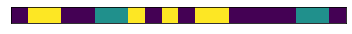

In [7]:
# let's plot
plt.imshow(neighborhood.reshape(-1, 1).T)
plt.xticks([])
plt.yticks([])


### Appendix: Breakdown of Code for Segregation 2D
Early stages of preparing the pipeline. Pipeline above has some updates not reflected here

In [8]:
# Parameters
n = 10 # one side of the neighborhood, so the neighborhood becomes n x n
agents = [0, 1, 2] # 0 is empty, 1 and 2 are the agents
props = [0.1, 0.45, 0.45] # proportions of agents must equal one
k = 3 # kernel size is the size around the agent to consider. This must be odd, k x k so we have a center = 0
thresholds = [0, 0.3, 0.3] # threshold - this is the proportion of similar agents in the locality of an agent for an agent to be happy


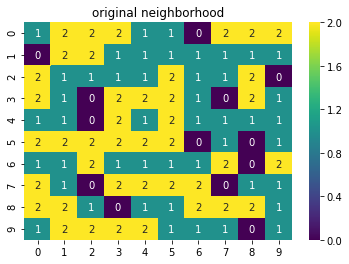

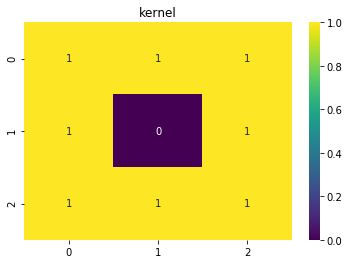

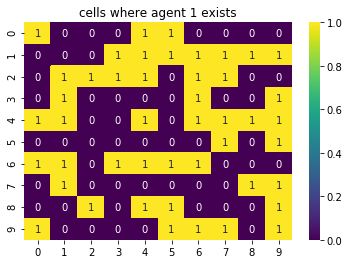

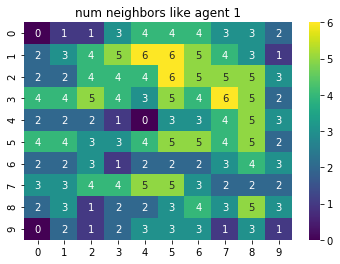

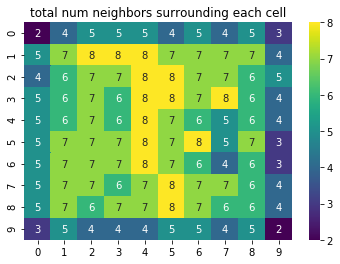

In [9]:
# here we break down, the algo to count neighbors per agent
# make the kernel
kernel = np.ones(shape=(k, k))
kernel[k//2, k//2] = 0 # we make the center of the kernel 0 because we don't want to count the agent in the center

# we randomly make a neighborhood based on proportions of agents and size n x n
np.random.seed(42) # we can adjust the seed when we're running multiple samples so we still retain replicability
neighborhood = np.random.choice(agents, size=(n, n), replace=True, p=props) 

# counting the number of neighbors using correlate2d
# in Think Complexity, they used boundary="wrap"
# this "tiles" the neighborhood matrix so for the cell in the top right corner, we consider the cells in the left and bottom areas
# Here, we don't do that so we use boudary="fill" or we pad with nulls. This implies that the neighborhood has edges like in real life.
# Note that Schelling made this same assumption that there are edges.
# mode (counts) surrounding a cell can thus be calculated by running the "neighborhood window" or kernel from top left to bottom right.
# mode='same' just means that we return a matrix (of counts of similar neighbors surrounding each cell) with the same shape as the neighborhood
# the conditions are just there to tell the function whether to count or not
agent_1 = neighborhood == 1 # say we want to know the number of agents similar to 1
agent_2 = neighborhood == 2 # say we want to know the number of agents similar to 1

options = dict(mode='same', boundary='fill') # here's a neat way to define arguments
num_neighbors_1 = correlate2d(agent_1, kernel, **options)
num_neighbors_2 = correlate2d(agent_2, kernel, **options)
num_neighbors_all = num_neighbors_1 + num_neighbors_2 # so we exclude empty cells

options=dict(annot=True, cmap='viridis')
sns.heatmap(neighborhood, **options)
plt.title('original neighborhood')
plt.show()
sns.heatmap(kernel, **options)
plt.title('kernel')
plt.show()
sns.heatmap(agent_1, **options)
plt.title('cells where agent 1 exists')
plt.show()
sns.heatmap(num_neighbors_1, **options)
plt.title('num neighbors like agent 1')
plt.show()
sns.heatmap(num_neighbors_all, **options)
plt.title('total num neighbors surrounding each cell')
plt.show()

/Users/prince.javier/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater_equal
/Users/prince.javier/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater_equal


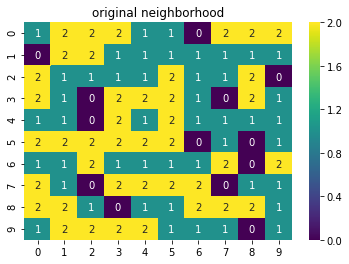

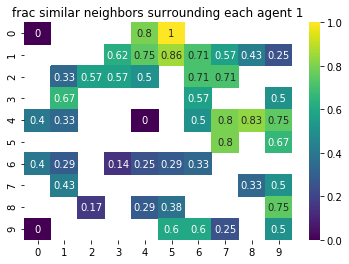

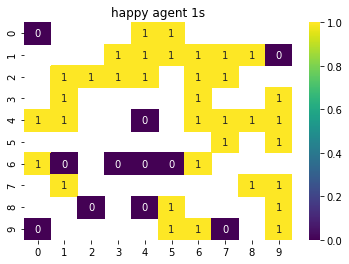

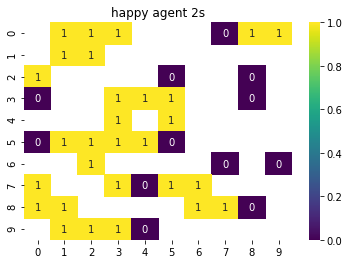

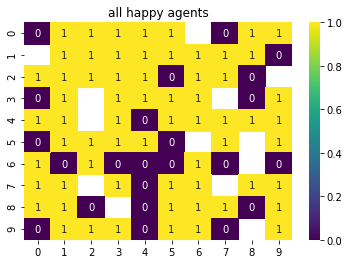

average similar prop agent 1, 2, total 0.4936853002070393 0.4326074332171893 0.4649014778325123


In [10]:
# now we find which agents are happy and which agents are not
# we use the threshold proportions
frac_neighbors_1 = num_neighbors_1 / num_neighbors_all
frac_neighbors_2 = num_neighbors_2 / num_neighbors_all
frac_neighbors_all = np.where(agent_1, frac_neighbors_1, frac_neighbors_2) # if agent_1, use agent 1 props, else agent 2

# remember to just select the agent (1, or 2) and remove empty cells
is_empty = neighborhood == 0    
frac_neighbors_all = np.where(is_empty, np.nan, frac_neighbors_all) # then we remove empty       

# making dissimiular/empty cells around an agent null
frac_neighbors_1 = np.where(neighborhood==1, frac_neighbors_1, np.nan)
frac_neighbors_2 = np.where(neighborhood==2, frac_neighbors_2, np.nan)       

# getting happy agents        
threshold_1 = thresholds[1] # threshold of agent 1
threshold_2 = thresholds[2] # threshold of agent 2

frac_happy_1 = frac_neighbors_1 >= threshold_1
frac_happy_2 = frac_neighbors_2 >= threshold_2

# let's be sure and remove dissimilar agents
frac_happy_1 = np.where(neighborhood==1, frac_happy_1, np.nan)
frac_happy_2 = np.where(neighborhood==2, frac_happy_2, np.nan)        

# remove empty cells    
frac_happy_all = np.where(agent_1, frac_happy_1, frac_happy_2) # if agent_1, use agent 1 happiness, else agent 2
frac_happy_all = np.where(is_empty, np.nan, frac_happy_all) # then we remove empty

# calculate the proportion of like-neighbors per agent
avg_frac_1 = np.nanmean(frac_neighbors_1)
avg_frac_2 = np.nanmean(frac_neighbors_2)
avg_frac_all = np.nanmean(frac_neighbors_all) 

# # for tracking of segregation over time
# avg_similarities_1.append(avg_frac_1)
# avg_similarities_2.append(avg_frac_2)
# avg_similarities_all.append(avg_frac_all)  

sns.heatmap(neighborhood, **options)
plt.title('original neighborhood')
plt.show()

sns.heatmap(frac_neighbors_1, **options)
plt.title('frac similar neighbors surrounding each agent 1')
plt.show()

sns.heatmap(frac_happy_1, **options)
plt.title('happy agent 1s')
plt.show()

sns.heatmap(frac_happy_2, **options)
plt.title('happy agent 2s')
plt.show()

sns.heatmap(frac_happy_all, **options)
plt.title('all happy agents')
plt.show()

print('average similar prop agent 1, 2, total', avg_frac_1, avg_frac_2, avg_frac_all)

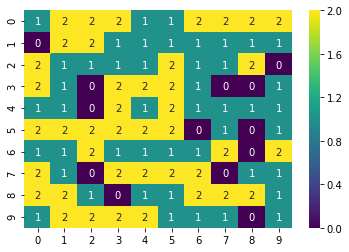

In [11]:
# now for each unhappy agent, we randomly place into an empty cell so they are happy
# we may impose a travel limit to just the local neighborhood
travel_lim=False

# get the coordinates of unhappy cells
unhappy_coords = [(i[0][0], i[0][1]) for i in list(zip(np.argwhere(frac_happy_all==0)))] # this is two lists that we need to convert to a (x, y)

# get the coordinates of empty cells
empty_coords = [(i[0][0], i[0][1]) for i in list(zip(np.argwhere(np.isnan(frac_happy_all))))]

# switch places one agent at a time
unhappy_agent_coord_ind = np.random.choice(range(len(unhappy_coords)))
unhappy_agent_coord = unhappy_coords[unhappy_agent_coord_ind]
unhappy_agent = neighborhood[unhappy_agent_coord]

if travel_lim:
#     we limit the possible empty locations to only that surrounding the selected agent
# coordinates surrounding the agent
    empty_coords = [i for i in empty_coords if i[0] >= unhappy_agent_coord[0] - k//2 
                             and i[0] <= unhappy_agent_coord[0] + k//2 
                             and i[1] >= unhappy_agent_coord[1] - k//2 
                             and i[1] <= unhappy_agent_coord[1] + k//2]
    empty_coord_ind = np.random.choice(range(len(empty_coords)))
    empty_coord = empty_coords[empty_coord_ind]        
    
else: # no travel limits    
    empty_coord_ind = np.random.choice(range(len(empty_coords)))
    empty_coord = empty_coords[empty_coord_ind]    

# then we switch an unhappy cell with an empty cell
neighborhood[empty_coord] = unhappy_agent
neighborhood[unhappy_agent_coord] = 0

sns.heatmap(neighborhood, **options)


### Appendix: Segregation with Bounded Neighborhood

In [12]:
# Parameters
n = 10 # one side of the neighborhood, so the neighborhood becomes n x n
agents = [0, 1, 2] # 0 is empty, 1 and 2 are the agents
props = [0.1, 0.45, 0.45] # proportions of agents must equal one
thresholds = [0.3, 0.3] # threshold - this is the proportion of similar agents in the locality of an agent for an agent to be happy


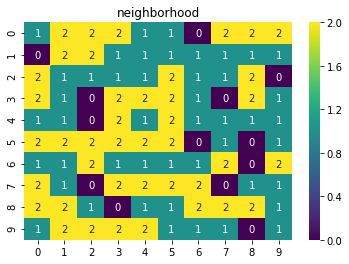

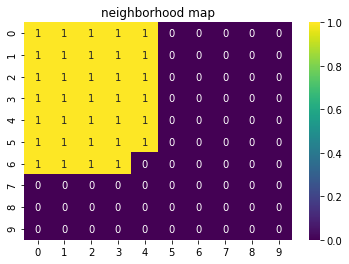

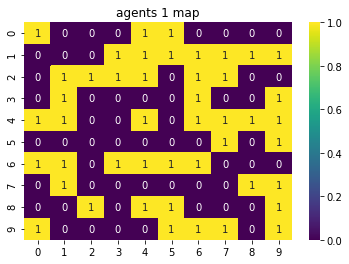

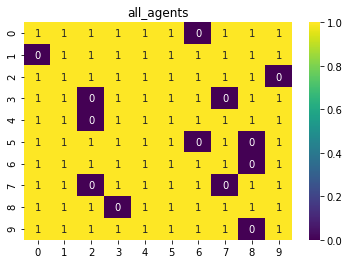

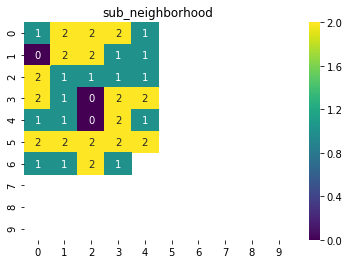

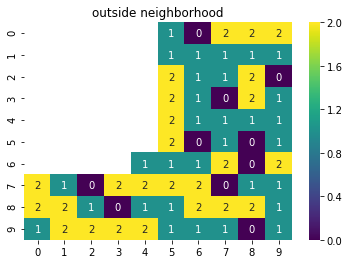

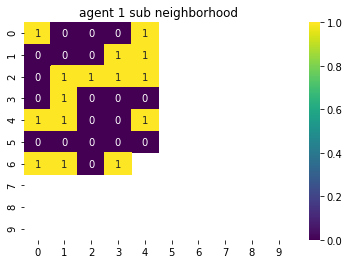

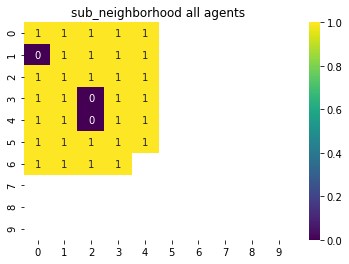

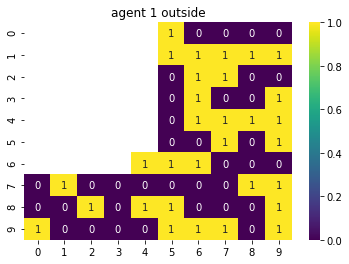

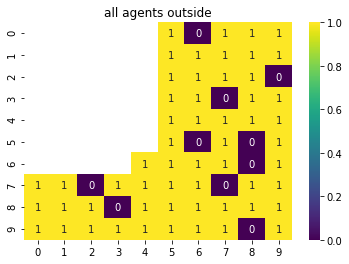

fraction of 1 agents inside neighborhood  0.4838709677419355 0.5161290322580645


In [13]:
# let's call the bounded neighborhood a sub-neighborhood
# let's still call the entire matrix/map the "neighborhood"
# we must first define the sub-neighborhood and its boundaries
# pattern of the neighborhood (1 = inside, 0 = outside)

# we randomly make a neighborhood based on proportions of agents and size n x n
np.random.seed(42) # we can adjust the seed when we're running multiple samples so we still retain replicability
neighborhood = np.random.choice(agents, size=(n, n), replace=True, p=props) 

pattern = np.array([[1, 1, 1, 0, 0, 0],
                    [1, 1, 1, 0, 0, 0],
                    [1, 1, 1, 0, 0, 0],
                    [1, 1, 1, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0]])

# get the agents for the entire neighborhood
# make empty spaces nan
agent_1 = np.where(neighborhood == 1, neighborhood, 0)  # say we want to know the number of agents similar to 1
agent_2 = np.where(neighborhood == 2, neighborhood, 0) # say we want to know the number of agents similar to 1
agent_all = neighborhood != 0

# get the actual size neighborhood "map" which tells us which is inside our outside the sub-neighborhood
neighborhood_map = resize(pattern, (n, n), anti_aliasing=False, preserve_range=True)
neighborhood_map = np.round(neighborhood_map)

# only get the values inside the sub-neighborhood via element-wise multiplication with the pattern
sub_neighborhood = np.multiply(neighborhood_map, neighborhood)
# make outside neighborhood nulls
sub_neighborhood = np.where(neighborhood_map==0, np.nan, sub_neighborhood)
# get outside of neighborhood
out_neighborhood = np.where(neighborhood_map==1, np.nan, neighborhood)

# get the agents inside the subneighborhood
agent_1_sub = np.where(neighborhood_map==1, agent_1==1, np.nan)
agent_2_sub = np.where(neighborhood_map==1, agent_2==2, np.nan)
agent_all_sub = np.where(neighborhood_map==1, agent_all!=0, np.nan)

# # get the agents outside the subneighborhood
agent_1_out = np.where(neighborhood_map==0, agent_1==1, np.nan)
agent_2_out = np.where(neighborhood_map==0, agent_2==2, np.nan)
agent_all_out = np.where(neighborhood_map==0, agent_all, np.nan)

# we can compute the fraction of similar agents / total agents in the neighborhood
agent_1_frac = np.nansum(agent_1_sub)/np.nansum(agent_all_sub)
agent_2_frac = np.nansum(agent_2_sub)/np.nansum(agent_all_sub)

options=dict(annot=True, cmap='viridis')
sns.heatmap(neighborhood, **options)
plt.title('neighborhood')
plt.show()

sns.heatmap(neighborhood_map, **options)
plt.title('neighborhood map')
plt.show()

sns.heatmap(agent_1, **options)
plt.title('agents 1 map')
plt.show()

sns.heatmap(agent_all, **options)
plt.title('all_agents')
plt.show()

sns.heatmap(sub_neighborhood, **options)
plt.title('sub_neighborhood')
plt.show()

sns.heatmap(out_neighborhood, **options)
plt.title('outside neighborhood')
plt.show()

sns.heatmap(agent_1_sub, **options)
plt.title('agent 1 sub neighborhood')
plt.show()

sns.heatmap(agent_all_sub, **options)
plt.title('sub_neighborhood all agents')
plt.show()

sns.heatmap(agent_1_out, **options)
plt.title('agent 1 outside')
plt.show()

sns.heatmap(agent_all_out, **options)
plt.title('all agents outside')
plt.show()

print('fraction of 1 agents inside neighborhood ', agent_1_frac, agent_2_frac)

[]

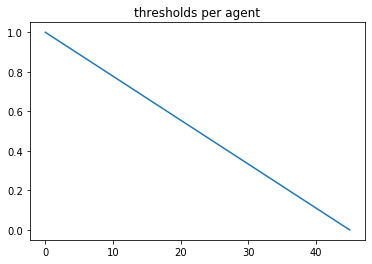

In [14]:
# since we now know the fraction of like-agents at any one time,
# we can define a threshold distribution per agent and that will define whether they will move out or move in
# we need a way to track if an individual with a certain threshold is inside our outside the sub-neighborhood
# we initialize by randomly assigning whether an agent with a threshold is inside our outside with 0s or 1s

# define a distribution
def thresh_dist(x):
    # accepts an array and applies a function
    # must be between 0 and 1
    return -x/np.max(x)+1 # decreasing slope (0 is most tolerant, last user is least toleratn)

thresh_agent_1 = thresh_dist(np.array(range(int(np.nansum(agent_1))))) # index is the agent, value is threshold
thresh_agent_2 = thresh_dist(np.array(range(int(np.nansum(agent_2))))) # index is the agent, value is threshold

plt.plot(thresh_agent_1)
plt.title('thresholds per agent')
plt.plot()

In [15]:
len(thresh_agent_2)

82

In [16]:
# number of agents inside and outside
num_inside_1 = int(np.nansum(agent_1_sub))
num_inside_2 = int(np.nansum(agent_2_sub))
num_outside_1 = int(np.nansum(agent_1) - num_inside_1)
num_outside_2 = int(np.nansum(agent_2) - num_inside_2)

# threshold locs - > we use this to check which of the list of thresholds (agents) are inside (1) or outside (0)
# we don't need a specific agent tied to a specific threshold
# we just need to pick an agent inside/outside and then indicate in the threshold that it's now 1 or 0
# we only need to initialize once
thresh_locs_1 = np.array(list(np.ones(shape=(num_inside_1))) + list(np.zeros(shape=(num_outside_1))))
thresh_locs_2 = np.array(list(np.ones(shape=(num_inside_2))) + list(np.zeros(shape=(num_outside_2))))
np.random.shuffle(thresh_locs_1)
np.random.shuffle(thresh_locs_2)

thresh_locs_1

array([0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.])

In [17]:
# get indices of those inside which we will use to map back to actual thresholds
# the index of a threshold that's breached will then be used to change the mapping of whether inside or outside in thresh_locs_1 or 2
inside_inds_1 = np.nonzero(thresh_locs_1)
inside_inds_2 = np.nonzero(thresh_locs_2)

# get indices of those outside
outside_inds_1 = np.nonzero(1-thresh_locs_1)
outside_inds_2 = np.nonzero(1-thresh_locs_2)

# we put these here and run as a group because it's easier to track
# we get the thresholds for those inside and check which ones of them (from highest to lowest) will need to get out
highest_ind_inside_1 = np.argsort(thresh_agent_1[inside_inds_1])[0]
highest_thresh_inside_1 = thresh_agent_1[highest_ind_inside_1]

highest_ind_inside_2 = np.argsort(thresh_agent_2[inside_inds_2])[0]
highest_thresh_inside_2 = thresh_agent_2[highest_ind_inside_2]

# we get the thresholds for those outside and check from lowest to highest which ones of them will go in
lowest_ind_outside_1 = np.argsort(thresh_agent_1[outside_inds_1])[0]
lowest_thresh_outside_1 = thresh_agent_1[lowest_ind_outside_1]

lowest_ind_outside_2 = np.argsort(thresh_agent_2[outside_inds_2])[0]
lowest_thresh_outside_2 = thresh_agent_2[lowest_ind_outside_2]

# we randomly select between four options: check inside vs outside and agent 1 vs agent 2 like rolling a die
area_to_check = np.random.choice(['inside', 'outside'])
agent_to_check = np.random.choice([1, 2])

if area_to_check=='inside' and agent_to_check == 1:
    if highest_thresh_inside_1 >= agent_1_frac: # this agent leaves if the proportion needed is higher than actual
        # we randomly select one agent from the subneighborhood and randomly place in a vacant area outside
        sources = [(i[0][0], i[0][1]) for i in list(zip(np.argwhere(agent_1_sub==1)))] # this is two lists that we need to convert to a (x, y)        
        source_ind = np.random.choice(range(len(sources)))
        source = sources[source_ind]

        # randomly get empty coordinates outside the sub-neighborhood
        dests = [(i[0][0], i[0][1]) for i in list(zip(np.argwhere(agent_all_out==0)))]
        dest_ind = np.random.choice(range(len(dests)))        
        dest = dests[dest_ind]
        
        # switch cells
        neighborhood[dest] = 1
        neighborhood[source] = 0        
        
        # we update the agent-threshold location tracker thresh_locs_1
        thresh_locs_1[highest_ind_inside_1] = 0 # now outside
        
if area_to_check=='inside' and agent_to_check == 2:
    if highest_thresh_inside_2 >= agent_2_frac: # this agent leaves if the proportion needed is higher than actual
        # we randomly select one agent from the subneighborhood and randomly place in a vacant area outside
        sources = [(i[0][0], i[0][1]) for i in list(zip(np.argwhere(agent_2_sub==1)))] # this is two lists that we need to convert to a (x, y)        
        source_ind = np.random.choice(range(len(sources)))
        source = sources[source_ind]

        # randomly get empty coordinates outside the sub-neighborhood
        dests = [(i[0][0], i[0][1]) for i in list(zip(np.argwhere(agent_all_out==0)))]
        dest_ind = np.random.choice(range(len(dests)))        
        dest = dests[dest_ind]
        
        # switch cells
        neighborhood[dest] = 2
        neighborhood[source] = 0        
        
        # we update the agent-threshold location tracker thresh_locs_1
        thresh_locs_2[highest_ind_inside_2] = 0 # now outside   
        
if area_to_check=='outside' and agent_to_check == 1:
    if lowest_thresh_outside_1 <= agent_1_frac: # this agent enters if the proportion needed is lower than actual
        # we randomly select one agent from the subneighborhood and randomly place in a vacant area outside
        sources = [(i[0][0], i[0][1]) for i in list(zip(np.argwhere(agent_1_out==1)))] # this is two lists that we need to convert to a (x, y)        
        source_ind = np.random.choice(range(len(sources)))
        source = sources[source_ind]

        # randomly get empty coordinates outside the sub-neighborhood
        dests = [(i[0][0], i[0][1]) for i in list(zip(np.argwhere(agent_all_sub==0)))] # empty space inside
        dest_ind = np.random.choice(range(len(dests)))        
        dest = dests[dest_ind]
        
        # switch cells
        neighborhood[dest] = 1
        neighborhood[source] = 0        
        
        # we update the agent-threshold location tracker thresh_locs_1
        thresh_locs_1[lowest_ind_outside_1] = 1 # now outside 
        
if area_to_check=='outside' and agent_to_check == 2:
    if lowest_thresh_outside_2 <= agent_2_frac: # this agent enters if the proportion needed is lower than actual
        # we randomly select one agent from the subneighborhood and randomly place in a vacant area outside
        sources = [(i[0][0], i[0][1]) for i in list(zip(np.argwhere(agent_2_out==1)))] # this is two lists that we need to convert to a (x, y)        
        source_ind = np.random.choice(range(len(sources)))
        source = sources[source_ind]

        # randomly get empty coordinates outside the sub-neighborhood
        dests = [(i[0][0], i[0][1]) for i in list(zip(np.argwhere(agent_all_sub==0)))] # empty space inside
        dest_ind = np.random.choice(range(len(dests)))        
        dest = dests[dest_ind]
        
        # switch cells
        neighborhood[dest] = 2
        neighborhood[source] = 0        
        
        # we update the agent-threshold location tracker thresh_locs_1
        thresh_locs_2[lowest_ind_outside_2] = 1 # now outside                

# # we compare against the current proportion

print(thresh_locs_1)



[0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0.
 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]


### Appendix: Breakdown of Threshold Model Code

In [18]:
# since we now know the fraction of like-agents at any one time,
# we can define a threshold distribution per agent and that will define whether they will activate or not
# define a distribution
def linear_dist(x):
    # accepts an array and applies a function
    # must be between 0 and 1
    y = x/np.max(x)
    return y

# thresholds from a normal distribution - this is what Granovetter used
# returns proportion of people having the given threshold
def norm_dist(x, mean, stdev):
    np.random.seed(42)
    y = np.random.normal(loc=mean, scale=stdev, size=len(x))
    y = np.array(sorted(y))
    y = np.clip(y, 0, 1)
    return y

# inverse gaussian
def inv_norm_dist(x, mean):
    np.random.seed(42)
    y = invgauss.rvs(mean, size=len(x))
    y = np.array(sorted(y))
    y = np.clip(y, 0, 1)
    return y    

def exp_dist(x, a, b, c):
    np.random.seed(42)
    y = a ** (x + b) + c
    y = np.array(sorted(y))
    y = np.clip(y, 0, 1)
    return y    

In [19]:
def plot_thresh_gif(dir_):
    with open(f'{dir_}/movie.gif','rb') as f:
        display(Image(data=f.read(), format='png'))

In [20]:
# proportion activated tracker
def run_thresh_sim(neighborhood, props, thresh, new_dir):
    
    try:
        os.mkdir('charts/threshold/')
    except:
        pass
    
    try:
        os.mkdir(new_dir)
        print(f'{new_dir} created')
    except:
        print(f'{new_dir} exists')    

    rs = []
    for iter_ in range(30):

        r1 = neighborhood.sum() / len(props) # proportion activated
        r2 = sum(thresh <= r1)/len(thresh)

        rs.append(r1)

        to_activate = int(len(props) * r2) - neighborhood.sum() # increemental agents to activate
        if to_activate > 0: # we will activate more
        # randomly select m zeros to activate
            zero_coords = [(i[0][0], i[0][1]) for i in zip(np.argwhere(neighborhood==0))]

            selected_inds = np.random.choice(range(len(zero_coords)), size=to_activate, replace=False)
            selected_coords = np.array(zero_coords)[selected_inds]    

            for i in range(len(selected_coords)):
                neighborhood[(selected_coords[i][0], selected_coords[i][1])] = 1        

        if to_activate < 0: # we will deactivate
        # randomly select m zeros to activate
            one_coords = [(i[0][0], i[0][1]) for i in zip(np.argwhere(neighborhood==1))]

            selected_inds = np.random.choice(range(len(one_coords)), size=np.abs(to_activate), replace=False)
            selected_coords = np.array(one_coords)[selected_inds]    

            for i in range(len(selected_coords)):
                neighborhood[(selected_coords[i][0], selected_coords[i][1])] = 0           

        f = plt.figure(figsize=(6, 6))
        plt.imshow(neighborhood)
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        plt.savefig(f'{new_dir}/{str(iter_).zfill(5)}.png')
        plt.close()    

    # save gif
    filenames = glob.glob(f"{new_dir}/*.png")
    filenames = sorted(filenames)
    filenames = filenames + [filenames[-1]] * 20 # so we freeze at the output
    images=[]
    for filename in filenames:
        images.append(imageio.imread(filename))
    imageio.mimsave(f'{new_dir}/movie.gif', images)
    
    return rs


### Appendix: Breakdown of Standing Ovation Model

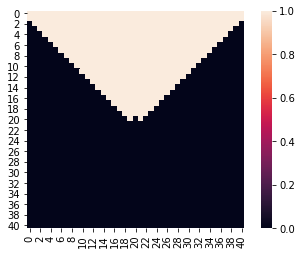

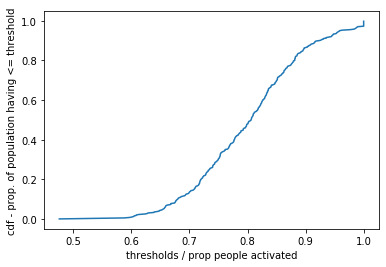

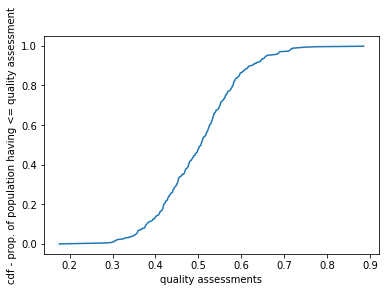

sanity check prop people having thresh < 0.6  0.01


In [24]:
# parameters
n = 20 # we make a grid of n x n individuals who are either activated or not
q_thresh = 0.5 # quality threshold

# then we check activation from peer pressure
# this is the cone of vision pattern around each agent
# the agent is at the center
# If we want some information leakage from the back, we may indicate with 1s
# should be (2n + 1) * (2n + 1) so it's odd and even if we get the user at the back, the user can still see the stage

kernel = np.zeros(shape=(2*n + 1, 2*n + 1))
plt.imshow(kernel)
for i in range(2*n+1):
    for j in range(2*n+1):
        if i <= n and j >= i -1 and j <= -i + 2*n+1:
            kernel[i, j] = 1
# we then exclude the middle
kernel[n, n] = 0

sns.heatmap(kernel, annot=False)
plt.show()

# peer pressure threshold parameters
p_mean, p_stdev = 0.8, 0.1
# quality assessment values distribution params
q_mean, q_stdev = 0.5, 0.1

# For visualization purposes
# This is calculated in the function
# generate thresholds
props = np.arange(0, 1, 1/(n**2)) # agents are indices, value is the (cumulative proportion)
p_thresh = norm_dist(props, mean=p_mean, stdev=p_stdev) # agents are indices thresholds for peer pressure

# quality assessment
q_assess = norm_dist(props, mean=q_mean, stdev=q_stdev) # agents are indices thresholds for peer pressure

plt.plot(p_thresh, props)
plt.xlabel('thresholds / prop people activated')
plt.ylabel('cdf - prop. of population having <= threshold')
plt.show()

plt.plot(q_assess, props)
plt.xlabel('quality assessments')
plt.ylabel('cdf - prop. of population having <= quality assessment')
plt.show()

# sanity check
print('sanity check prop people having thresh < 0.6 ',sum(p_thresh<0.6)/len(p_thresh))


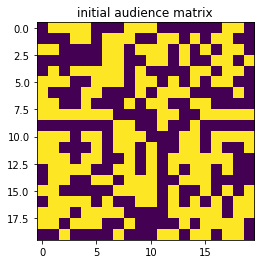

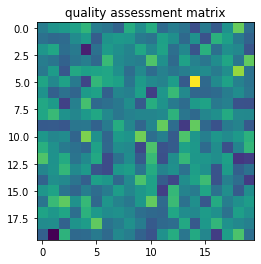

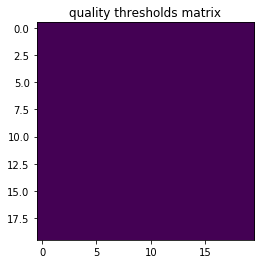

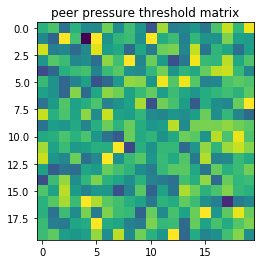

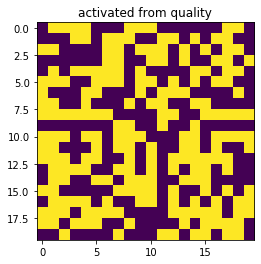

proportion activated  0.52


In [25]:
# generate thresholds
props = np.arange(0, 1, 1/(n**2)) # agents are indices, value is the (cumulative proportion)
p_thresh = norm_dist(props, mean=p_mean, stdev=p_stdev) # agents are indices thresholds for peer pressure

# shuffle the thresholds
np.random.seed(42)
np.random.shuffle(p_thresh)

# we randomly assign each user with different thresholds into the nxn matrix
# we can do this by making a matrix that maps the thresholds of each agent

# initialize matrices
np.random.seed(42)
act_matrix = np.zeros(shape=(n, n)) # whether standing or not

q_matrix = norm_dist(props, mean=q_mean, stdev=q_stdev) # get a quality assessment matrix from a (normal) distribution
np.random.shuffle(q_matrix)
q_matrix = q_matrix.reshape((n, n))

q_thresh_matrix = np.ones(shape=(n, n)) * q_thresh # quality thresholds e.g. 0.5
p_thresh_matrix = np.zeros(shape=(n, n)) # indicating agent's threshold re proportion of others standing up

# # we get the coordinates
coords = [(i[0][0], i[0][1]) for i in zip(np.argwhere(p_thresh_matrix==0))]

# we assign agents indicated by their thresholds randomly into the matrix
for i in range(len(coords)):
    x, y = coords[i][0], coords[i][1]
    p_thresh_matrix[x, y] = p_thresh[i]
    
# those whose quality thresholds are breached will activate
act_matrix_init = (q_matrix > q_thresh_matrix).astype(int) # initialize, we need this as the permanent standing agents
act_matrix = act_matrix_init.copy() # this is what we update per time

# prop activated
prop_act = act_matrix.sum() / (n * n)
    
# show matrices    
plt.imshow(act_matrix)
plt.title('initial audience matrix')
plt.show()

# show matrices    
plt.imshow(q_matrix)
plt.title('quality assessment matrix')
plt.show()

plt.imshow(q_thresh_matrix)
plt.title('quality thresholds matrix')
plt.show()

plt.imshow(p_thresh_matrix)
plt.title('peer pressure threshold matrix')
plt.show()

plt.imshow(act_matrix)
plt.title('activated from quality')
plt.show()    

print('proportion activated ', prop_act)


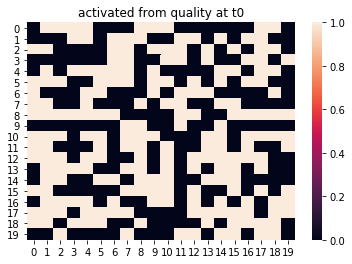

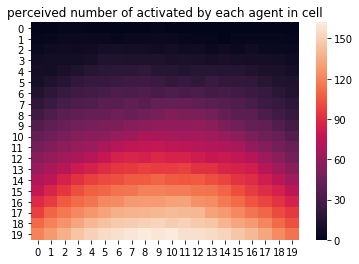

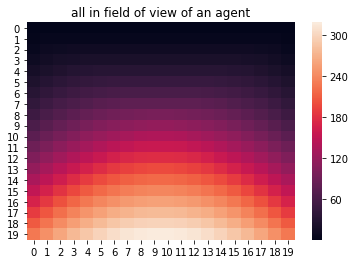

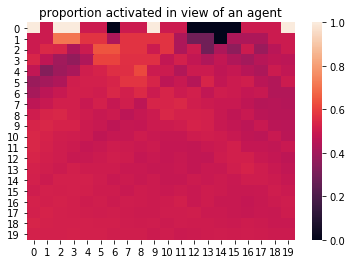

In [27]:
# number of activated agents in field of vision
options = dict(mode='same', boundary='fill') # here's a neat way to define arguments
act_perceived = correlate2d(act_matrix, kernel, **options) # perceived activation
all_perceived = correlate2d(np.ones(shape=(n,n)), kernel, **options) # all agents in field of view
act_prop_perceived = act_perceived / all_perceived

# those who will activate at t + 1
act_new = (act_prop_perceived > p_thresh_matrix).astype(int)

# those who will deactivate at t + 1
deact_new = (act_prop_perceived < p_thresh_matrix).astype(int)

sns.heatmap(act_matrix, annot=False)
plt.title('activated from quality at t0')
plt.show()

sns.heatmap(act_perceived, annot=False)
plt.title('perceived number of activated by each agent in cell')
plt.show()

sns.heatmap(all_perceived, annot=False)
plt.title('all in field of view of an agent')
plt.show()

sns.heatmap(act_prop_perceived, annot=False)
plt.title('proportion activated in view of an agent')
plt.show()

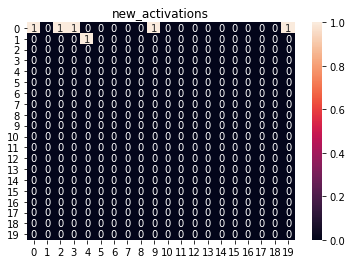

In [28]:
sns.heatmap(act_new, annot=True)
plt.title('new_activations')
plt.show()

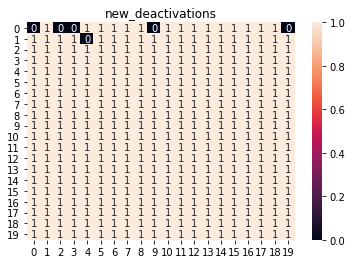

In [29]:
sns.heatmap(deact_new, annot=True)
plt.title('new_deactivations')
plt.show()

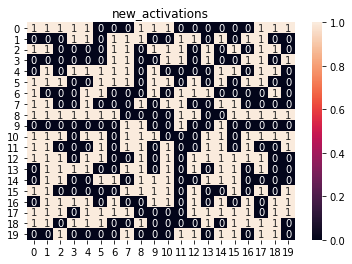

In [30]:
# update activation matrix
act_matrix = ((act_matrix + act_new) != 0).astype(int)
sns.heatmap(act_matrix, annot=True)
plt.title('new_activations')
plt.show()

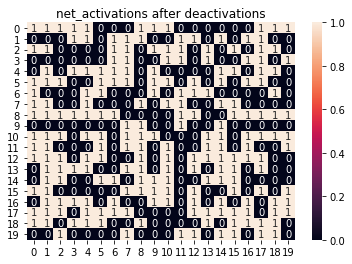

In [31]:
# those who deactivate will sit down while those who stood up from quality will remain standing up
# reverse deact new so we can do elementwise multiplication to deactivate
deact_new_inv = 1 - deact_new
act_matrix = np.multiply(act_matrix, deact_new_inv) + act_matrix_init # we deactivate but add back permanently standing agents

act_matrix = (act_matrix != 0).astype(int)
sns.heatmap(act_matrix, annot=True)
plt.title('net_activations after deactivations')
plt.show()
